/tmp/ipykernel_18729/265722876.py:422: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


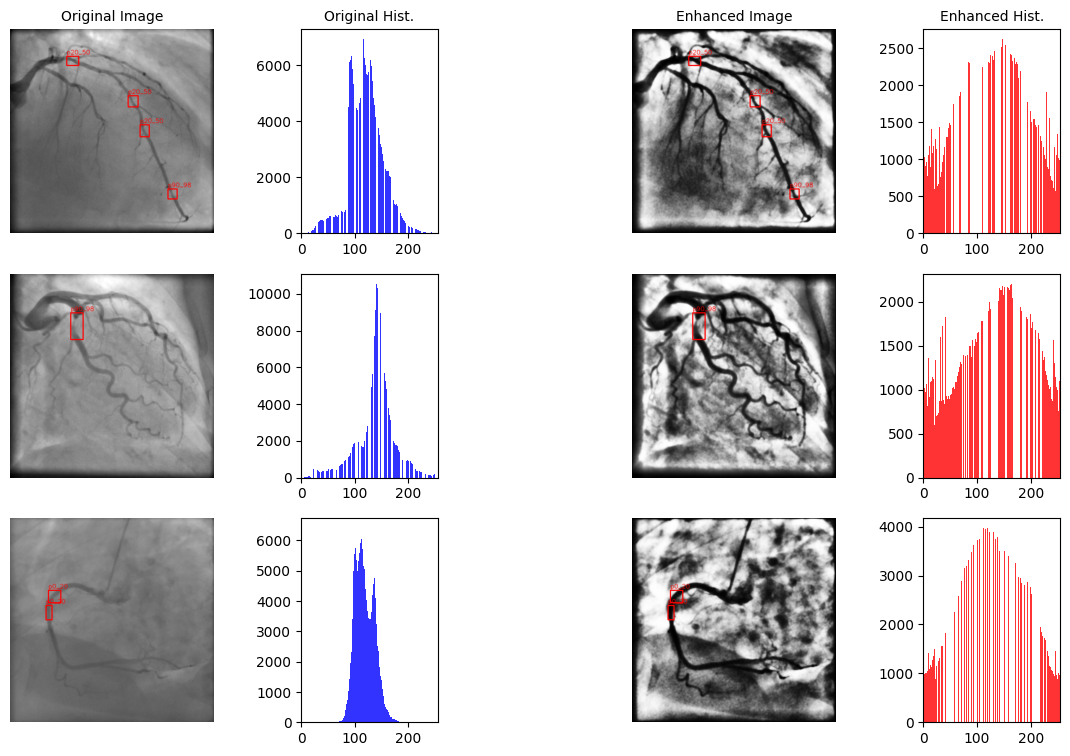

In [46]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import matplotlib.gridspec as gridspec

import cv2

def draw_bounding_boxes_yolo(image, txt_file_path, color=(0, 255, 0), thickness=2):
    """
    Reads YOLO-format bounding boxes from a text file and draws them on the given image.

    Args:
        image (numpy.ndarray): The image on which to draw (e.g. loaded via cv2.imread).
        txt_file_path (str): Path to the YOLO .txt file containing bounding boxes.
        color (tuple): BGR color of the rectangle outlines, default is green.
        thickness (int): Thickness of the rectangle outlines.

    Returns:
        numpy.ndarray: The annotated image with rectangles drawn.
    """
    # Get image dimensions.
    img_height, img_width = image.shape[:2]

    # Read each line from the .txt file.
    with open(txt_file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        # Example line: "0 0.5 0.5 0.2 0.3"
        parts = line.strip().split()
        if len(parts) < 5:
            # Skip empty or invalid lines.
            continue

        # class_id is parts[0], but we don't necessarily need it for drawing the box.
        # You might want to parse it if you want to color boxes differently by class.
        # class_id = int(parts[0])

        x_center_rel = float(parts[1])
        y_center_rel = float(parts[2])
        w_rel        = float(parts[3])
        h_rel        = float(parts[4])

        # Convert from relative to absolute pixel coordinates.
        x_center = x_center_rel * img_width
        y_center = y_center_rel * img_height
        w_box    = w_rel * img_width
        h_box    = h_rel * img_height

        # Calculate box corner coordinates.
        x1 = int(x_center - w_box / 2)
        y1 = int(y_center - h_box / 2)
        x2 = int(x_center + w_box / 2)
        y2 = int(y_center + h_box / 2)

        # Draw the bounding box.
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)

    return image


def filtering_smoothing_equalization(image: np.ndarray, window_size: int, sigma: float) -> np.ndarray:
    """
    Gaussian smoothing + Histogram Equalization for a grayscale image.
    """
    # --- Step 1: Gaussian Smoothing ---
    c = window_size // 2
    kernel = np.zeros((window_size, window_size), dtype=np.float32)
    for i in range(window_size):
        for j in range(window_size):
            kernel[i, j] = (1 / (2 * math.pi * sigma**2)) * math.exp(
                -(((i - c)**2 + (j - c)**2) / (2 * sigma**2))
            )
    kernel /= np.sum(kernel)
    smoothed = cv2.filter2D(image, -1, kernel)
    
    # --- Step 2: Histogram Equalization ---
    hist, _ = np.histogram(smoothed.flatten(), bins=256, range=(0, 256))
    cdf = hist.cumsum()
    cdf_masked = np.ma.masked_equal(cdf, 0)
    cdf_min = cdf_masked.min()
    total_pixels = smoothed.size
    cdf_normalized = (cdf_masked - cdf_min) * 255 / (total_pixels - cdf_min)
    cdf_final = np.ma.filled(cdf_normalized, 0).astype('uint8')
    equalized = cdf_final[smoothed]
    return equalized

def fse_enhancement_manual(
    image: np.ndarray, 
    window_size: int = 5, 
    sigma: float = 1.0
) -> np.ndarray:
    """
    FSE-like enhancement with:
      1) Manual Gaussian smoothing w/ zero-padding.
      2) Manual histogram equalization as in the paper.
    """
    # --- 1. Manual Gaussian Smoothing ---
    c = window_size // 2
    # Build a 5x5 Gaussian kernel (or variable window_size)
    g_kernel = np.zeros((window_size, window_size), dtype=np.float64)
    for i in range(window_size):
        for j in range(window_size):
            dist_sq = (i - c)**2 + (j - c)**2
            g_kernel[i, j] = math.exp(-dist_sq / (2*sigma**2))
    g_kernel /= g_kernel.sum()  # Normalize

    # Prepare output array and zero-padded input
    rows, cols = image.shape
    smoothed = np.zeros_like(image, dtype=np.float64)
    padded = np.pad(image, pad_width=c, mode='constant', constant_values=0)

    # Convolve manually
    for x in range(rows):
        for y in range(cols):
            region = padded[x : x + window_size, y : y + window_size]
            smoothed[x, y] = np.sum(region * g_kernel)

    # Clip & convert to 8-bit if original is float or out of [0,255]
    smoothed_8u = np.clip(smoothed, 0, 255).astype(np.uint8)

    # --- 2. Manual Histogram Equalization ---
    # (Paper-like formula: 
    #   H(a) = round( (CDF(a) - CDF(min)) / (M*N - 1) * (L - 1 ) )
    # )
    hist, _ = np.histogram(smoothed_8u, bins=256, range=(0,256))
    cdf = np.cumsum(hist)

    # Get the smallest nonzero cdf value
    cdf_nonzero = cdf[cdf > 0]
    if len(cdf_nonzero) == 0:
        return smoothed_8u  # Edge case: all pixels same value
    cdf_min = cdf_nonzero.min()

    M, N = rows, cols
    L = 256

    # Build a mapping from the original intensity to the new (equalized) intensity
    mapping = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        if cdf[i] == 0:
            # If no pixels have intensity i
            mapping[i] = 0
        else:
            mapping[i] = np.round(
                (cdf[i] - cdf_min) / ((M*N) - 1) * (L - 1)
            ).astype(np.uint8)

    # Apply the lookup
    enhanced = mapping[smoothed_8u]
    return enhanced

import numpy as np
import math

def fse_enhancement(image: np.ndarray, window_size: int, sigma: float) -> np.ndarray:
    # 1) Manual Gaussian smoothing
    c = window_size // 2
    # Build the 5x5 Gaussian kernel
    g_kernel = np.zeros((window_size, window_size), dtype=np.float64)
    for i in range(window_size):
        for j in range(window_size):
            g_kernel[i, j] = math.exp(-((i - c)**2 + (j - c)**2)/(2*sigma**2))
    g_kernel /= g_kernel.sum()

    # Convolve manually
    rows, cols = image.shape
    smoothed = np.zeros_like(image, dtype=np.float64)

    # You can decide how to handle borders; e.g. pad with zeros
    padded = np.pad(image, pad_width=c, mode='constant', constant_values=0)

    for x in range(rows):
        for y in range(cols):
            region = padded[x:x+window_size, y:y+window_size]
            smoothed[x, y] = np.sum(region * g_kernel)

    # 2) Histogram equalization with exact formula
    #    Convert smoothed to uint8 if desired [0..255]
    smoothed_8u = np.clip(smoothed, 0, 255).astype(np.uint8)

    # Build histogram
    hist, _ = np.histogram(smoothed_8u, bins=256, range=(0,256))
    cdf = np.cumsum(hist)
    # The paper's formula suggests:
    cdf_min = cdf[cdf>0].min()
    M, N = rows, cols
    L = 256

    # Build the mapping array
    mapping = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        if cdf[i] == 0:
            mapping[i] = 0
        else:
            # Round(...) from the paper
            mapping[i] = np.round((cdf[i] - cdf_min)/((M*N) - 1) * (L - 1)).astype(np.uint8)

    # Map the smoothed image
    enhanced = mapping[smoothed_8u]
    return enhanced


def fse_enhancement_opencv(
    image: np.ndarray, 
    window_size: int = 5, 
    sigma: float = 1.0, 
    apply_gamma: bool = False, 
    gamma: float = 1.0
) -> np.ndarray:
    """
    FSE-like enhancement with:
      1) Gaussian smoothing using cv2.filter2D (controllable border mode)
      2) Built-in cv2.equalizeHist
      3) Optional gamma correction
    """
    # --- 1. Construct Gaussian kernel in OpenCV style ---
    g_kernel_1d = cv2.getGaussianKernel(ksize=window_size, sigma=sigma)
    g_kernel_2d = g_kernel_1d @ g_kernel_1d.T  # Outer product => 2D kernel

    # Use filter2D with a chosen border mode (try CONSTANT or REPLICATE)
    smoothed = cv2.filter2D(
        image, 
        ddepth=-1, 
        kernel=g_kernel_2d, 
        borderType=cv2.BORDER_CONSTANT  # or BORDER_REPLICATE
    )

    # Convert to 8-bit if necessary
    smoothed_8u = np.clip(smoothed, 0, 255).astype(np.uint8)

    # --- 2. Built-in Histogram Equalization ---
    equalized = cv2.equalizeHist(smoothed_8u)

    # --- 3. (Optional) Gamma Correction ---
    # If the paper’s figure is brighter/darker, adjusting gamma can help match it.
    if apply_gamma and gamma != 1.0:
        # Scale to [0,1], apply gamma, then back to [0,255].
        img_f = equalized.astype(np.float32) / 255.0
        gamma_corrected = np.power(img_f, gamma)  # img^(gamma)
        gamma_corrected = (gamma_corrected * 255).clip(0, 255).astype(np.uint8)
        return gamma_corrected
    else:
        return equalized


def draw_bounding_boxes(image: np.ndarray, bbox_file_path: str) -> np.ndarray:
    """
    Draw bounding boxes on a copy of the input image (grayscale or BGR).
    """
    annotated_image = image.copy()
    if len(annotated_image.shape) == 2:  
        annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_GRAY2BGR)
    
    with open(bbox_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            x_str, y_str, w_str, h_str = parts[:4]
            severity_label = parts[4]
            x, y, w, h = map(int, [x_str, y_str, w_str, h_str])
            x2, y2 = x + w, y + h
            
            cv2.rectangle(annotated_image, (x, y), (x2, y2), (0, 0, 255), 2)
            cv2.putText(
                annotated_image, severity_label, (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255),
                thickness=1, lineType=cv2.LINE_AA
            )
    return annotated_image

import cv2
import numpy as np

def fse_clahe_enhancement(
    image: np.ndarray,
    window_size: int = 5,
    sigma: float = 1.0,
    clipLimit: float = 2.0,
    tileGridSize: tuple = (8, 8),
    border_type: int = cv2.BORDER_CONSTANT
) -> np.ndarray:
    """
    FSE-like enhancement + CLAHE:
      1) Gaussian smoothing (5x5 by default) using OpenCV's filter2D
      2) Apply Contrast-Limited Adaptive Histogram Equalization (CLAHE)
    Args:
        image: Grayscale image, expected 8-bit (0..255) or convertible to 8-bit
        window_size: Size of the Gaussian kernel
        sigma: Standard deviation for the Gaussian kernel
        clipLimit: Threshold for contrast clipping in CLAHE
        tileGridSize: Size of the grid for the histogram equalization
        border_type: How the filter handles image borders (CONSTANT, REPLICATE, etc.)
    Returns:
        The enhanced image (uint8).
    """

    # 1) Create a 2D Gaussian kernel using OpenCV's getGaussianKernel
    g_kernel_1d = cv2.getGaussianKernel(ksize=window_size, sigma=sigma)
    g_kernel_2d = g_kernel_1d @ g_kernel_1d.T  # Outer product to make 2D kernel

    # Make sure the source image is 8-bit for filter2D
    if image.dtype != np.uint8:
        img_8u = np.clip(image, 0, 255).astype(np.uint8)
    else:
        img_8u = image

    # 2) Apply the Gaussian filter
    smoothed = cv2.filter2D(
        img_8u,
        ddepth=-1,
        kernel=g_kernel_2d,
        borderType=border_type
    )

    # 3) Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    clahe_result = clahe.apply(smoothed)

    return clahe_result


# ----------------------------------------------------------------
# Example usage for multiple images:
input_img_paths = [
    "/home/mariopasc/Python/Datasets/CADICA/selectedVideos/p12/v2/input/p12_v2_00025.png",
    "/home/mariopasc/Python/Datasets/CADICA/selectedVideos/p32/v3/input/p32_v3_00044.png",
    "/home/mariopasc/Python/Datasets/CADICA/selectedVideos/p19/v11/input/p19_v11_00023.png"
]

bbox_file_paths = [
    "/home/mariopasc/Python/Datasets/CADICA/selectedVideos/p12/v2/groundtruth/p12_v2_00025.txt",
    "/home/mariopasc/Python/Datasets/CADICA/selectedVideos/p32/v3/groundtruth/p32_v3_00044.txt",
    "/home/mariopasc/Python/Datasets/CADICA/selectedVideos/p19/v11/groundtruth/p19_v11_00023.txt"
]

original_images     = []
enhanced_images     = []
original_annotated  = []
enhanced_annotated  = []
orig_histograms     = []
enh_histograms      = []

for img_path, bbox_path in zip(input_img_paths, bbox_file_paths):
    gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if gray is None:
        print(f"Error: Unable to read {img_path}")
        continue
    
    # Enhance the image
    enhanced_clahe = fse_clahe_enhancement(gray, window_size=5, sigma=1.0,
                                        clipLimit=4.0, tileGridSize=(8,8),
                                        border_type=cv2.BORDER_CONSTANT)
    enh = fse_enhancement_opencv(enhanced_clahe, window_size=5, sigma=1.0)

    # Annotate bounding boxes for display
    orig_annotated_img = draw_bounding_boxes(gray, bbox_path)
    enh_annotated_img  = draw_bounding_boxes(enh,  bbox_path)
    
    # Compute histograms
    orig_hist, _ = np.histogram(gray.flatten(), bins=256, range=(0, 256))
    enh_hist,  _ = np.histogram(enh.flatten(),  bins=256, range=(0, 256))
    
    # Store everything
    original_images.append(gray)
    enhanced_images.append(enh)
    original_annotated.append(orig_annotated_img)
    enhanced_annotated.append(enh_annotated_img)
    orig_histograms.append(orig_hist)
    enh_histograms.append(enh_hist)

# ----------------------------------------------------------------
# Plot in N rows, 4 columns: Original Image, Original Hist, Enhanced Image, Enhanced Hist
# We'll create 5 columns using GridSpec: columns [0,1], [3,4] + a spacer column [2].
N = len(original_images)

fig = plt.figure(figsize=(14, 3*N))
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(nrows=N, ncols=5, width_ratios=[2, 1, 0.4, 2, 1],
                       wspace=0.3, hspace=0.2)

for i in range(N):
    # --- Column 0: Original image ---
    ax_orig_img = fig.add_subplot(gs[i, 0])
    ax_orig_img.imshow(cv2.cvtColor(original_annotated[i], cv2.COLOR_BGR2RGB))
    if i == 0: ax_orig_img.set_title("Original Image", fontsize=10)
    ax_orig_img.axis("off")

    # --- Column 1: Original histogram (using plt.hist with weights=...) ---
    ax_orig_hist = fig.add_subplot(gs[i, 1])
    bins = np.arange(257)  # edges for 256 bins
    # Here we treat each bin as a single point with a weight = count
    # so that .hist() draws bars. 
    ax_orig_hist.hist(bins[:-1], bins, weights=orig_histograms[i],
                      color='blue', alpha=0.8)
    if i == 0: ax_orig_hist.set_title("Original Hist.", fontsize=10)
    ax_orig_hist.set_xlim([0, 255])

    # Spacer column at index 2 -- skip it

    # --- Column 3: Enhanced image ---
    ax_enh_img = fig.add_subplot(gs[i, 3])
    ax_enh_img.imshow(cv2.cvtColor(enhanced_annotated[i], cv2.COLOR_BGR2RGB))
    if i == 0: ax_enh_img.set_title("Enhanced Image", fontsize=10)
    ax_enh_img.axis("off")

    # --- Column 4: Enhanced histogram (again .hist with weights=...) ---
    ax_enh_hist = fig.add_subplot(gs[i, 4])
    ax_enh_hist.hist(bins[:-1], bins, weights=enh_histograms[i],
                     color='red', alpha=0.8)
    if i == 0: ax_enh_hist.set_title("Enhanced Hist.", fontsize=10)
    ax_enh_hist.set_xlim([0, 255])

    # Label the row
    ax_orig_img.set_ylabel(os.path.basename(input_img_paths[i]),
                           rotation=90, fontsize=8, labelpad=10)

plt.tight_layout()
plt.savefig("fse_processing_hist.svg", dpi=150)
plt.show()

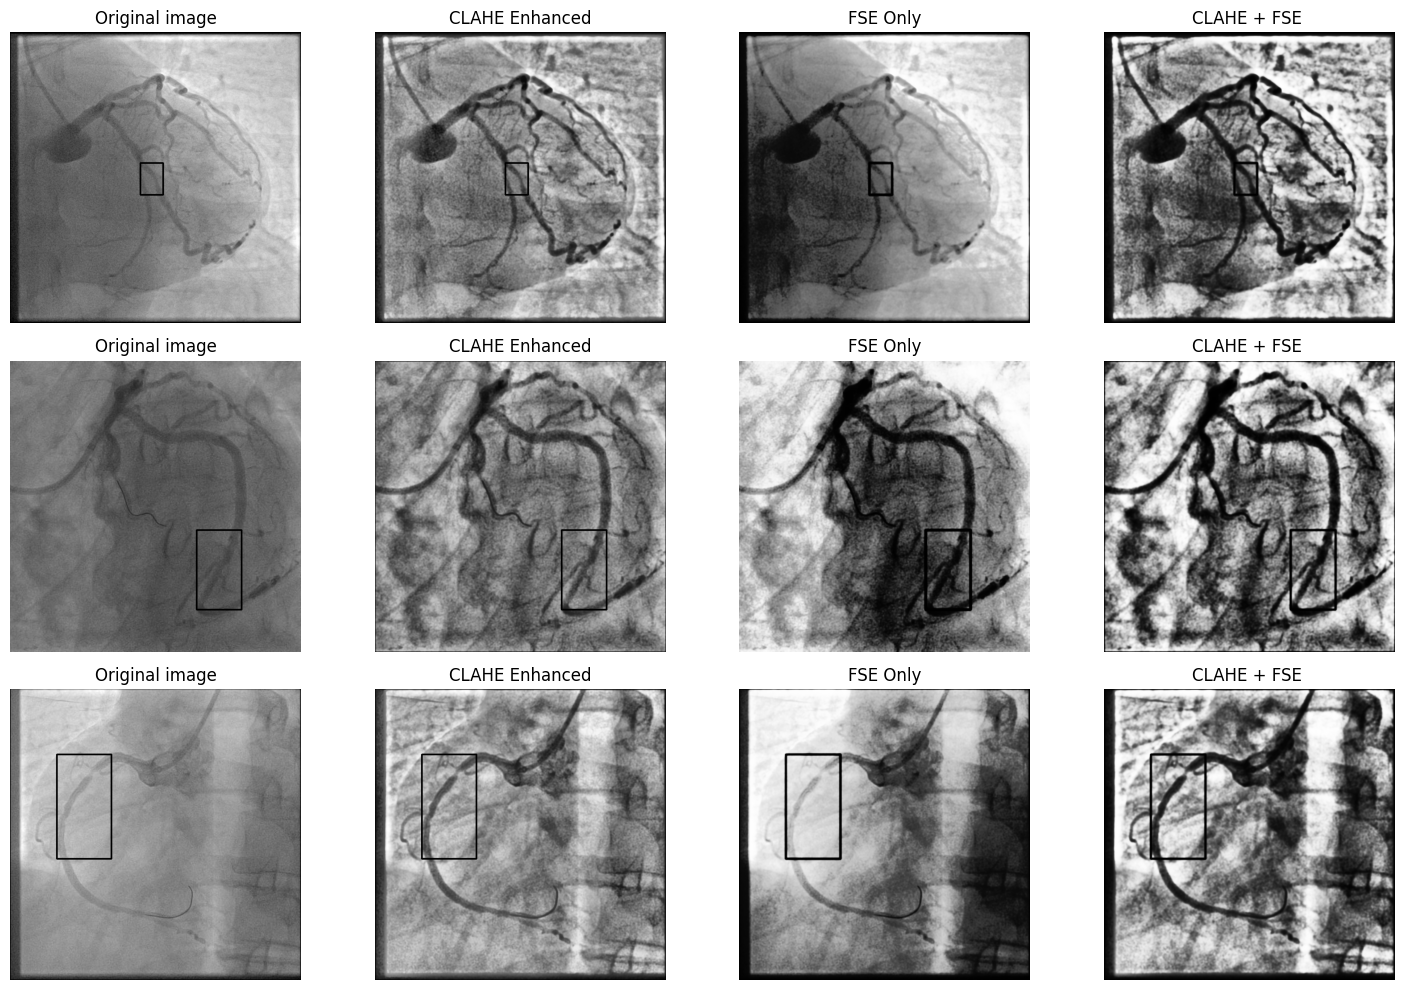

In [45]:
base = "/home/mariopasc/Python/Datasets/COMBINED/ICA_DETECTION"

names = ["arcadetest_p1_v1_00001", "arcadetrain_p1_v1_00001", "arcadeval_p1_v1_00001"]

_, axes = plt.subplots(len(names), 4, figsize=(15,10))

for i, name in enumerate(names):
    image_path = os.path.join(base, "images", name + ".png")
    bbox = os.path.join(base, "labels", name + ".txt")

    image=cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    enhanced_clahe = fse_clahe_enhancement(image, window_size=5, sigma=1.0,
                                        clipLimit=4.0, tileGridSize=(8,8),
                                        border_type=cv2.BORDER_CONSTANT)


    original_annotated = draw_bounding_boxes_yolo(image=image, txt_file_path=bbox)
    clahe = draw_bounding_boxes_yolo(image=enhanced_clahe, txt_file_path=bbox)
    fse_only = draw_bounding_boxes_yolo(image=filtering_smoothing_equalization(image, window_size=5, sigma=1.0), txt_file_path=bbox)
    fse_clahe = draw_bounding_boxes_yolo(image=fse_enhancement_opencv(enhanced_clahe, window_size=5, sigma=1.0), txt_file_path=bbox)


    axes[i, 0].imshow(cv2.cvtColor(original_annotated, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title("Original image")
    axes[i, 1].imshow(cv2.cvtColor(clahe, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title("CLAHE Enhanced")
    axes[i, 2].imshow(cv2.cvtColor(fse_only, cv2.COLOR_BGR2RGB))
    axes[i, 2].set_title("FSE Only")
    axes[i, 3].imshow(cv2.cvtColor(fse_clahe, cv2.COLOR_BGR2RGB))
    axes[i, 3].set_title("CLAHE + FSE ")


    axes[i, 0].axis('off')
    axes[i, 1].axis('off')
    axes[i, 2].axis('off')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.savefig("fse.svg")
plt.show()


# bbox visualization

In [2]:
import cv2
import numpy as np
import xml.etree.ElementTree as ET

import cv2

def draw_and_convert_cadica_txt_to_yolo(
    image, 
    txt_file_path,
    output_txt_path=None,
    color=(0, 255, 0),
    thickness=2,
    label_map=None
):
    """
    Reads bounding boxes from CADICA .txt (x, y, w, h, label),
    converts them to YOLO format, draws them on 'image',
    and optionally writes YOLO lines to 'output_txt_path'.
    
    :param image:         Loaded image as NumPy array.
    :param txt_file_path: Path to the .txt file with CADICA bounding boxes.
    :param output_txt_path: Where to save the YOLO label file (str). If None, skip writing.
    :param color:         BGR color for bounding box.
    :param thickness:     Line thickness.
    :param label_map:     A dict or function to convert label strings to class IDs. 
                          E.g.: {"p20_50": 0, "p90_98": 1} or a custom parse logic.
    :return: Annotated image.
    """
    h_img, w_img = image.shape[:2]
    yolo_lines = []
    
    with open(txt_file_path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5:
            continue  # skip bad lines
        
        # x, y, w, h
        x = float(parts[0])
        y = float(parts[1])
        w = float(parts[2])
        h = float(parts[3])
        
        # The label can be parsed or use a known map
        label_str = parts[4]  
        if label_map is not None:
            class_id = label_map.get(label_str, 0)  # fallback class id
        else:
            # Or parse the digits from label_str in some custom way
            class_id = 0
        
        # Convert to YOLO
        x_center = (x + w / 2.0) / w_img
        y_center = (y + h / 2.0) / h_img
        width    = w / w_img
        height   = h / h_img
        
        yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        
        # Draw for visualization
        top_left = (int(x), int(y))
        bottom_right = (int(x + w), int(y + h))
        cv2.rectangle(image, top_left, bottom_right, color, thickness)
    
    if output_txt_path is not None:
        with open(output_txt_path, 'w') as f:
            for line in yolo_lines:
                f.write(line + "\n")
    
    return image


def draw_bounding_boxes_yolo(image: np.ndarray, bbox_file_path: str) -> np.ndarray:
    """
    Draw bounding boxes on a copy of the input image (grayscale or BGR) using the YOLO normalized XYWH format.
    Each line in the file should contain at least 5 tokens: class_id, x_center, y_center, width, height.
    Coordinates are normalized relative to image width and height.
    
    :param image: Input image (grayscale or BGR) as a NumPy array.
    :param bbox_file_path: Path to the text file containing YOLO bounding box annotations.
    :return: Annotated image as a NumPy array.
    """
    annotated_image = image.copy()
    if len(annotated_image.shape) == 2:
        annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_GRAY2BGR)
    
    img_h, img_w = image.shape[:2]
    
    with open(bbox_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            class_id_str, x_center_str, y_center_str, w_str, h_str = parts[:5]
            # For label display, we can use the class id.
            label = class_id_str  
            # Convert normalized values to floats.
            x_center = float(x_center_str)
            y_center = float(y_center_str)
            w_norm = float(w_str)
            h_norm = float(h_str)
            # Convert normalized values to pixel values.
            box_w = int(w_norm * img_w)
            box_h = int(h_norm * img_h)
            x_center_pixel = int(x_center * img_w)
            y_center_pixel = int(y_center * img_h)
            # Compute top-left corner.
            x = x_center_pixel - box_w // 2
            y = y_center_pixel - box_h // 2
            x2 = x + box_w
            y2 = y + box_h
            
            cv2.rectangle(annotated_image, (x, y), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated_image, label, (x, y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0),
                        thickness=1, lineType=cv2.LINE_AA)
    return annotated_image

import xml.etree.ElementTree as ET
import cv2

def draw_and_convert_pascal_xml_to_yolo(
    image, 
    xml_file_path,
    output_txt_path=None,
    color=(0, 0, 255),
    thickness=2,
    label_map=None
):
    """
    Reads a Pascal-VOC XML (KEMEROVO format),
    converts to YOLO bounding boxes, and draws them on 'image'.
    Optionally writes YOLO lines to 'output_txt_path'.
    
    :param image:          Loaded image as NumPy array.
    :param xml_file_path:  Path to the Pascal VOC style XML.
    :param output_txt_path: Where to save YOLO label file. If None, skip writing.
    :param color:          BGR color for bounding boxes.
    :param thickness:      Line thickness.
    :param label_map:      Dict mapping from object name to class_id. E.g. {"Stenosis": 0}.
    :return:               Image with bounding boxes drawn.
    """
    # Parse XML
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    
    # Extract image size
    size_node = root.find("size")
    w_img = int(size_node.find("width").text)
    h_img = int(size_node.find("height").text)
    
    # If you prefer using the actual loaded image dimensions:
    # h_img, w_img = image.shape[:2]
    
    yolo_lines = []
    
    # Each <object> can have <name> and <bndbox>
    for obj in root.findall("object"):
        name = obj.find("name").text
        # Convert to class id
        if label_map is not None and name in label_map:
            class_id = label_map[name]
        else:
            class_id = 0  # default fallback
        
        bndbox = obj.find("bndbox")
        xmin = float(bndbox.find("xmin").text)
        ymin = float(bndbox.find("ymin").text)
        xmax = float(bndbox.find("xmax").text)
        ymax = float(bndbox.find("ymax").text)
        
        # Convert to YOLO
        x_center = (xmin + xmax) / 2.0 / w_img
        y_center = (ymin + ymax) / 2.0 / h_img
        width    = (xmax - xmin) / w_img
        height   = (ymax - ymin) / h_img
        
        yolo_line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
        yolo_lines.append(yolo_line)
        
        # Draw rectangle
        cv2.rectangle(
            image,
            (int(xmin), int(ymin)),
            (int(xmax), int(ymax)),
            color, thickness
        )
    
    # Write out if requested
    if output_txt_path is not None:
        with open(output_txt_path, 'w') as f:
            for line in yolo_lines:
                f.write(line + "\n")
    
    return image


import json
import cv2

def draw_and_convert_arcade_json_to_yolo(
    image, 
    json_file_path, 
    patient_id,
    output_txt_path=None,
    color=(255, 0, 0),
    thickness=2
):
    """
    Reads ARCADE-format JSON, converts to YOLO, 
    draws bounding boxes on 'image', 
    and (optionally) writes them to 'output_txt_path'.
    
    :param image:      Loaded image as a NumPy array (cv2.imread).
    :param json_file_path: Path to the ARCADE .json annotation.
    :param patient_id:  The image_id to filter on in 'annotations'.
    :param output_txt_path: Where to save the YOLO label file. If None, skip writing.
    :param color:       Color tuple for the bounding box lines (BGR).
    :param thickness:   Line thickness.
    :return:            Image with bounding boxes drawn (for display).
    """
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Get image dimensions (from the image array or from data["images"]).
    h_img, w_img = image.shape[:2]
    
    # Prepare a list for YOLO lines: [class_id, x_center, y_center, width, height]
    yolo_lines = []
    
    # Filter out the relevant annotations based on patient_id == annotation["image_id"]
    annotations = [ann for ann in data["annotations"] if ann["image_id"] == patient_id]
    
    for ann in annotations:
        # Convert category to zero-based index
        class_id = ann["category_id"] - 1
        
        # ARCADE 'bbox' is [x, y, w, h] in pixels
        x, y, w, h = ann["bbox"]
        
        # Compute YOLO format
        x_center = (x + w / 2.0) / w_img
        y_center = (y + h / 2.0) / h_img
        width    = w / w_img
        height   = h / h_img
        
        # Accumulate YOLO line (class x_center y_center w h)
        yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        
        # Draw for visualization
        top_left = (int(x), int(y))
        bottom_right = (int(x + w), int(y + h))
        cv2.rectangle(image, top_left, bottom_right, color, thickness)
    
    # If desired, write YOLO lines to a .txt file
    if output_txt_path is not None:
        with open(output_txt_path, 'w') as f:
            for line in yolo_lines:
                f.write(line + "\n")
    
    return image




### KEMEROVO

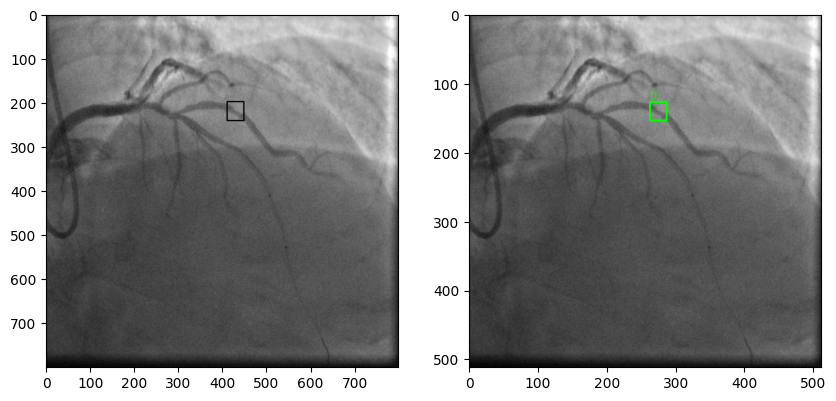

In [11]:
import os
import matplotlib.pyplot as plt

path_original = "/home/mariopasc/Python/Datasets/KEMEROVO/dataset/14_007_5_0048"
image_path_original = path_original + ".bmp"
annotation_path_original = path_original + ".xml"

path_post = "/home/mariopasc/Python/Datasets/COMBINED/ICA_DETECTION/"
image_path_yolo = os.path.join(path_post, "images/kemerovo_p007_v5_00048.png")
annotation_path_yolo = os.path.join(path_post, "labels/kemerovo_p007_v5_00048.txt")



image_original = cv2.imread(image_path_original, cv2.IMREAD_GRAYSCALE)
image_yolo = cv2.imread(image_path_yolo, cv2.IMREAD_GRAYSCALE)

annotated_original = draw_and_convert_pascal_xml_to_yolo(image=image_original, xml_file_path=annotation_path_original, output_txt_path="./pascal_yolo.txt")
annotated_yolo = draw_bounding_boxes_yolo(image=image_yolo, bbox_file_path=annotation_path_yolo)

_, axs = plt.subplots(1,2,figsize=(10,6))

axs[0].imshow(annotated_original, cmap = "gray")
axs[1].imshow(annotated_yolo, cmap="gray")

plt.show()

### CADICA

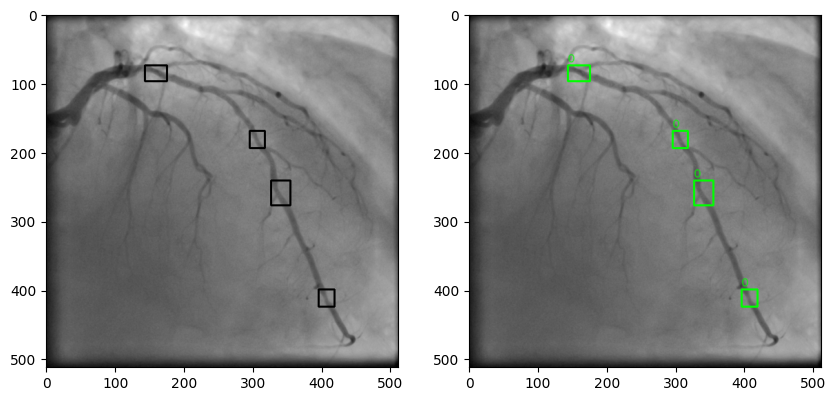

In [10]:
import os

path_original = "/home/mariopasc/Python/Datasets/CADICA/selectedVideos/p12/v2"
image_path_original = os.path.join(path_original, "input/p12_v2_00023.png")
annotation_path_original = os.path.join(path_original, "groundtruth/p12_v2_00023.txt")

path_post = "/home/mariopasc/Python/Datasets/COMBINED/ICA_DETECTION/"
image_path_yolo = os.path.join(path_post, "images/cadica_p12_v2_00023.png")
annotation_path_yolo = os.path.join(path_post, "labels/cadica_p12_v2_00023.txt")



image_original = cv2.imread(image_path_original, cv2.IMREAD_GRAYSCALE)
image_yolo = cv2.imread(image_path_yolo, cv2.IMREAD_GRAYSCALE)

annotated_original = draw_and_convert_cadica_txt_to_yolo(image=image_original, txt_file_path=annotation_path_original)
annotated_yolo = draw_bounding_boxes_yolo(image=image_yolo, bbox_file_path=annotation_path_yolo)

_, axs = plt.subplots(1,2,figsize=(10,6))

axs[0].imshow(annotated_original, cmap = "gray")
axs[1].imshow(annotated_yolo, cmap="gray")

plt.show()

### ARCADE

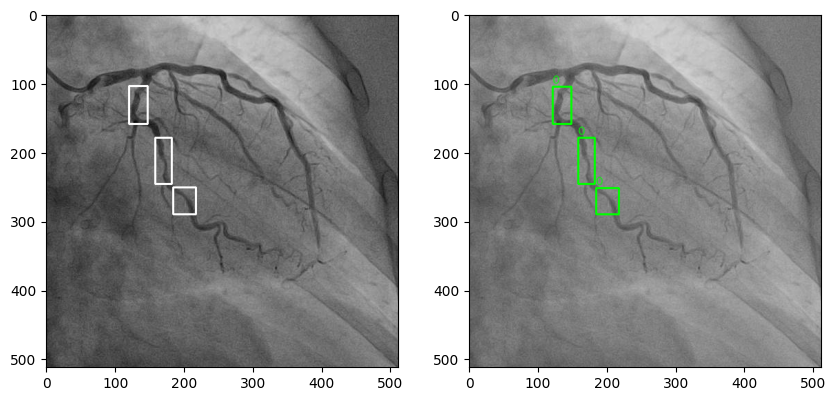

In [9]:
import os

path_original = "/home/mariopasc/Python/Datasets/ARCADE/stenosis/train"
image_path_original = os.path.join(path_original, "images/35.png")
annotation_path_original = os.path.join(path_original, "annotations/train.json")

path_post = "/home/mariopasc/Python/Datasets/COMBINED/ICA_DETECTION/"
image_path_yolo = os.path.join(path_post, "images/arcadetrain_p35_v35_00035.png")
annotation_path_yolo = os.path.join(path_post, "labels/arcadetrain_p35_v35_00035.txt")



image_original = cv2.imread(image_path_original, cv2.IMREAD_GRAYSCALE)
image_yolo = cv2.imread(image_path_yolo, cv2.IMREAD_GRAYSCALE)

annotated_original = draw_and_convert_arcade_json_to_yolo(image=image_original, json_file_path=annotation_path_original, patient_id=35)
annotated_yolo = draw_bounding_boxes_yolo(image=image_yolo, bbox_file_path=annotation_path_yolo)

_, axs = plt.subplots(1,2,figsize=(10,6))

axs[0].imshow(annotated_original, cmap = "gray")
axs[1].imshow(annotated_yolo, cmap="gray")

plt.show()